In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.max_columns = 60

### The data

In [2]:
df_all = pd.read_excel('all data v3.xlsx', 'iLab data.txt', index_col=None, na_values=['NA'])

Let's first use a particular session as a test case. We extract only the data relevant to that case

In [3]:
#Using the example used for sketch.
#(df_all.condition1 == 'Savanna') & (df_all.student1 == 'penguin') & (df_all.student2 == 'gorilla')]
df_test = df_all[df_all['Session Id'] == 'L-2567b17a:120eda25685:-8000']

Next we filter out all actions with "INCORRECT" outcomes

In [4]:
before = df_test.shape[0]
df_test = df_test[df_test['Outcome'] == 'CORRECT']
print "We are left with {0} rows out of {1}".format(df_test.shape[0],before)

We are left with 212 rows out of 285


In [5]:
df_test.head()

,Row ID,login name,condition1,condition2,student1,student2,student 3,class,Session Id,time first action,time last action,Time,Time Taken,Problem Name,Step Name,Attempt At Step,Outcome,Selection,Graph #,Method_Recognized_1_Copied,Method_Recognized_2_Copied,Action,Input,Next_Input,Feedback Text,CF(Method1),CF(Method2),CF(advice),CF(new1),CF(new2),CF(step1_1),CF(step1_2),CF(step1_3),CF(step1_4),CF(step1_5),CF(step1_6),CF(step1_7),CF(step1_8),CF(step2_1),CF(step2_2),CF(step2_3),CF(step2_4),CF(step2_5),CF(step2_6),CF(step2_7),CF(step2_8),Unnamed: 46,Unnamed: 47,Unnamed: 48,Input.1,Next_Input.1
15384,ID25386,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,00:57:29,NaN,00:57:29,NaN,trampoline,intuition UpdateComboBox,1.0,CORRECT,intuition,NaN,st1,st1,UpdateComboBox,Trampoline B,Dormin Button,Good. Now please work on part 2.,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15385,ID25387,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:57:40,00:00:11,trampoline,button1_9 ButtonPressed,1.0,CORRECT,button1_9,1.0,st1 9,st1,ButtonPressed,Dormin Button,Average,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15388,ID25390,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:11,00:00:09,trampoline,delete1 ButtonPressed,1.0,CORRECT,delete1,1.0,st1,st1,ButtonPressed,Delete step,Average,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15389,ID25391,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:21,00:00:10,trampoline,function1 UpdateComboBox,2.0,CORRECT,function1,1.0,st1 Average,st1,UpdateComboBox,Average,all,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15390,ID25392,penguin8gorilla8,Savanna,Savanna,penguin,gorilla,NaN,8,L-2567b17a:120eda25685:-8000,NaN,NaN,00:58:24,00:00:03,trampoline,pointsSelection1 UpdateComboBox,2.0,CORRECT,pointsSelection1,1.0,st1 Average all,st1,UpdateComboBox,all,Average,NaN,NaN,NaN,NaN,"1 ""3"" ""5"" ""7"" ""9""","3 ""4"" ""5"" ""6"" ""7""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def fix_time(time_start,x):
    if datetime.combine(date.min, x) >= datetime.combine(date.min, time_start):
        start = (datetime.combine(date.min, x) - datetime.combine(date.min, time_start)).total_seconds()
    else:
        #ex: this is the case when time_start is 59:00 min and x is 02:00 min, so we add an hour to find the duration
        start = (datetime.combine(date.min, x) + timedelta(hours=1) - datetime.combine(date.min, time_start)).total_seconds()
    return start

def get_duration(row):
    if pd.notnull(row['Timeshifted']):
        duration = (datetime.combine(date.min, row['Timeshifted']) - datetime.combine(date.min, row['Time'])).total_seconds()
    else:
        duration = 0
    return duration

Next we fix the time logs and convert them to seconds. We also recalculate the time between actions now that we have gotten rid of incorrect actions.

In [7]:
time_start = list(df_test['time first action'])[0]
df_test['Time_seconds'] = df_test[['Time']].applymap(lambda x: fix_time(time_start,x) )
df_test['Timeshifted'] = df_test[['Time']].shift(-1)
df_test['Duration'] = df_test[['Time','Timeshifted']].apply(get_duration, axis=1)

In [8]:
def get_method_usage(df,method):
    '''for each method, need a list of time coordinates for when
    they were used. These coordinates are in the format (start_time, duration)'''
    
    #first let's get time stamps for use of average
    method1 = zip(df[df['Method_Recognized_1_Copied'].str.contains(method)]['Time_seconds'],df[df['Method_Recognized_1_Copied'].str.contains(method)]['Duration'])
    method2 = zip(df[df['Method_Recognized_2_Copied'].str.contains(method)]['Time_seconds'],df[df['Method_Recognized_2_Copied'].str.contains(method)]['Duration'])
    return method1,method2

In [9]:
METHODS = ['Median','Average','Sum','all']
COLORS=iter(plt.cm.rainbow(np.linspace(0,1,len(METHODS))))
color =  {'Median': "#2ecc71",
    'Average': "#9b59b6",
    'Sum': "#3498db",
    'all': "#95a5a6",
    'Count': "#95a5a6",
    }

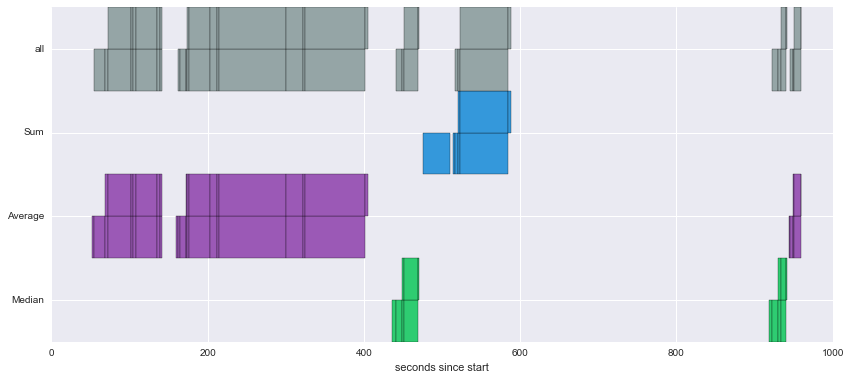

In [10]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot()
spacing =10
pos = 0
for i,method in enumerate(METHODS):
    m1,m2 = get_method_usage(df_test,method)
    ax.broken_barh(m1,(pos,spacing),facecolors=color[method],alpha=1)
    pos += spacing
    ax.broken_barh(m2,(pos,spacing),facecolors=color[method],alpha=1)
    pos += spacing
    
    
ax.set_xlabel('seconds since start')
ax.set_yticks(range(spacing,len(METHODS)*2*spacing,spacing*2))
ax.set_yticklabels(METHODS)
ax.grid(True)
plt.show()

## Let's add the interface actions

In [18]:
steps = list(set(df_test['Step Name']))
steps.sort()
for s in steps:
    print s

add1 ButtonPressed
add2 ButtonPressed
button1_1 ButtonPressed
button1_3 ButtonPressed
button1_7 ButtonPressed
button1_9 ButtonPressed
button2_1 ButtonPressed
button2_3 ButtonPressed
button2_4 ButtonPressed
button2_6 ButtonPressed
button2_7 ButtonPressed
button2_9 ButtonPressed
checkIntuition UpdateComboBox
delete1 ButtonPressed
delete2 ButtonPressed
deleteAll1 ButtonPressed
deleteAll2 ButtonPressed
evaluation UpdateComboBox
fakeDone ButtonPressed
function1 UpdateComboBox
function2 UpdateComboBox
intuition UpdateComboBox
operator1_1 UpdateComboBox
operator1_2 UpdateComboBox
operator1_3 UpdateComboBox
operator2_1 UpdateComboBox
operator2_2 UpdateComboBox
operator2_3 UpdateComboBox
pointsSelection1 UpdateComboBox
pointsSelection2 UpdateComboBox
step1_1 ButtonPressed
step1_2 ButtonPressed
step2_1 ButtonPressed
step2_2 ButtonPressed
submit ButtonPressed
use1 ButtonPressed
use2 ButtonPressed


In [19]:
interface_actions = ["checkIntuition UpdateComboBox","evaluation UpdateComboBox","fakeDone ButtonPressed","submit ButtonPressed"]

In [25]:
color = {"checkIntuition UpdateComboBox": "#2ecc71",
"evaluation UpdateComboBox": "#9b59b6",
"fakeDone ButtonPressed": "#3498db",
"submit ButtonPressed": "#95a5a6"}

In [26]:
def get_interface_action_usage(df,action):
    '''for each interface action, need a list of time coordinates for when
    they were used. These coordinates are in the format (start_time, duration)'''
    
    #first let's get time stamps for use of average
    action = zip(df[df['Step Name'].str.contains(action)]['Time_seconds'],df[df['Step Name'].str.contains(action)]['Duration'])
    return action

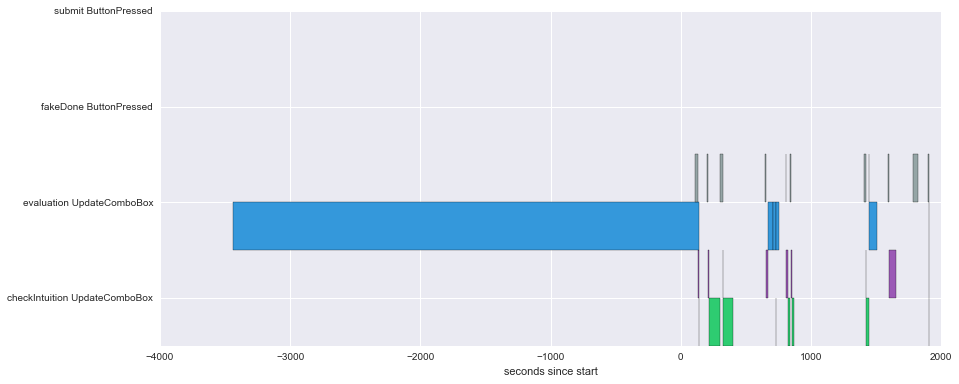

In [27]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot()
spacing =10
pos = 0
for i,action in enumerate(interface_actions):
    action_use = get_interface_action_usage(df_test,action)
    ax.broken_barh(action_use,(pos,spacing),facecolors=color[action],alpha=1)
    pos += spacing
    
    
ax.set_xlabel('seconds since start')
ax.set_yticks(range(spacing,len(interface_actions)*2*spacing,spacing*2))
ax.set_yticklabels(interface_actions)
ax.grid(True)
plt.show()